<a href="https://colab.research.google.com/github/ShivajiMallela/Deep-learning-with-Tensorflow/blob/main/10_time_series_forecasting_in_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 10. Milestone Project 3: Time Series Forecasting in TensorFlow (BitPredict 💰📈)

The goal of this notebook is to help you get familiar with working with time series data.

In this project, we’ll build a series of models to attempt to predict the price of Bitcoin.

Welcome to Milestone Project 3, BitPredict 💰📈!

> 🔑 **Note:** ⚠️ This is not financial advice. As you'll see, time series forecasting for stock market prices can be quite challenging.

## What is a Time Series Problem?

Time series problems involve data collected over time.

Examples include:
- The number of staff members in a company over 10 years
- Sales of computers over the past 5 years
- Electricity usage over the past 50 years

Time series can range from short (seconds/minutes) to long (years/decades). The problems you investigate can generally be categorized into two types:


| Problem Type | Examples | Output |
| ------------ | -------- | ------ |
| **Classification** | Anomaly detection, time series identification (e.g., identifying the source of a time series) | Discrete (a label) |
| **Forecasting** | Predicting stock market prices, forecasting future product demand, determining inventory requirements | Continuous (a number) |

In both cases, a supervised learning approach is typically used, meaning you have example data with associated labels.

For instance, in forecasting Bitcoin prices, your data could be the historical prices of Bitcoin over the past month, and the label could be today’s price (the label isn’t tomorrow’s price because that’s what we’re trying to predict).

So, can you guess what kind of problem BitPredict 💰📈 is?

## What We’re Going to Cover

Are you ready? We have a lot to go through:

* **Get Time Series Data**:
  - Load historical Bitcoin prices using pandas/Python's CSV module
* **Format Data for a Time Series Problem**:
  - Creating training and test sets (the wrong way)
  - Creating training and test sets (the right way)
  - Visualizing time series data
  - Turning time series data into a supervised learning problem (windowing)
  - Preparing univariate and multivariate (more than one variable) data
* **Evaluating a Time Series Forecasting Model**
* **Setting Up a Series of Deep Learning Modelling Experiments**:
  - Dense (fully-connected) networks
  - Sequence models (LSTM and 1D CNN)
  - Ensembling (combining multiple models together)
  - Multivariate models
  - Replicating the N-BEATS algorithm using TensorFlow layer subclassing
* **Creating a Model Checkpoint** to save the best performing model during training
* **Making Predictions (Forecasts)** with a Time Series Model
* **Creating Prediction Intervals** for Time Series Model Forecasts
* **Discussing Two Different Types of Uncertainty in Machine Learning**: Data Uncertainty and Model Uncertainty
* **Demonstrating the Challenges of Forecasting in an Open System** (the Turkey Problem)


## Get Data

To build a time series forecasting model, the first thing we need is data.

Since we’re aiming to predict the price of Bitcoin, we’ll require historical Bitcoin data.

Specifically, we’ll be using Bitcoin prices from **01 October 2013** to **18 May 2021**.

### Why these dates?

- **01 October 2013**: This is when our data source ([Coindesk](https://www.coindesk.com/price/bitcoin)) started recording Bitcoin prices.
- **18 May 2021**: This is the date when this notebook was created by instructor.

If you’re following this notebook at a later date, you can apply the same methods to predict on newer data—you’ll just need to adjust the data source accordingly.

> 📖 **Resource:** To get the historical Bitcoin data, visit the [Coindesk page for Bitcoin prices](https://www.coindesk.com/price/bitcoin), click on "All," then click on "Export Data" and select "CSV."

You can also access the data we’re using from [GitHub](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv).


In [1]:
# Download Bitcoin historical data from GitHub
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-08-21 19:02:27--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-08-21 19:02:27 (5.15 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas
Now we've got some data to work with, let's import it using pandas so we can visualize it.

Because our data is in **CSV (comma separated values)** format (a very common data format for time series), we'll use the pandas [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) function.

And because our data has a date component, we'll tell pandas to parse the dates using the `parse_dates` parameter passing it the name our of the date column ("Date").

In [2]:
#import with pandas
import pandas as pd
# parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates = ['Date'],
                 index_col = ['Date']) # parse the date column

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
len(df)

2787

In [5]:
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={"Closing Price (USD)":"Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


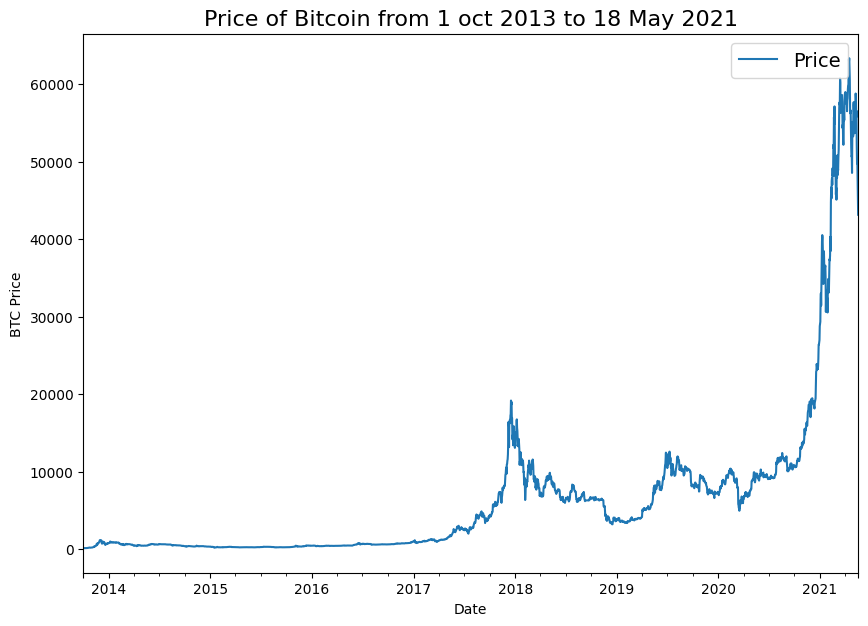

In [6]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);